# Descripción
Un avión vuela con velocidad 
$V$
 a 
$Ha$
 metros del suelo en dirección a un cañón como se muestra en la figura.

El cañón tiene forma de trapecio isósceles invertido, de una altura 
$H
c$
, largo 
$L$
 y ángulo 
$α$
 con respecto al horizonte.

Cuando se encuentra a una distancia 
$d$
 del borde del cañón, el avión suelta una bomba.

![Imagen](im2.png)



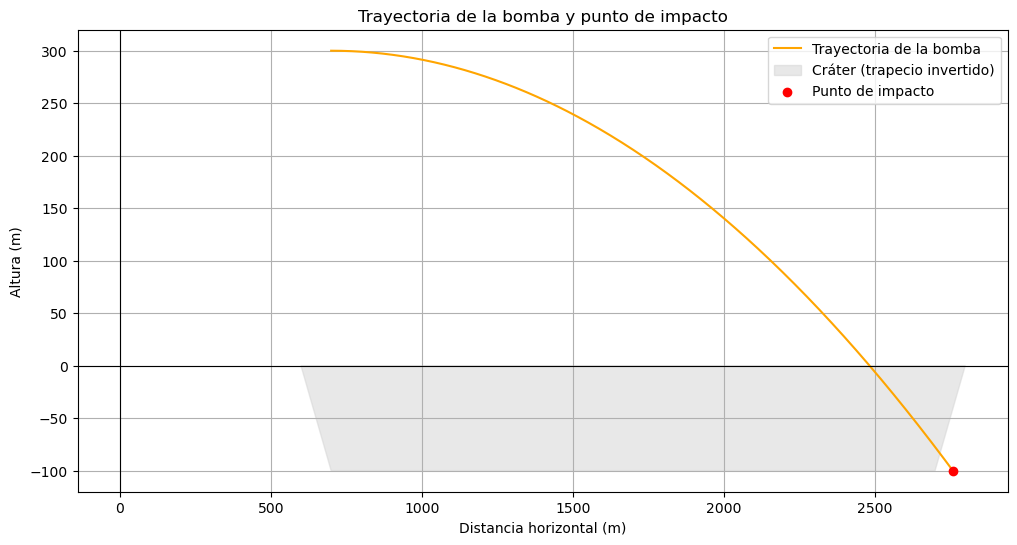

Punto de impacto: x = 2759.06 m, y = -100.00 m


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de entrada
ha = 300  # Altura inicial de la bomba
hc = -100  # Altura del fondo del cráter
L = 2000  # Longitud horizontal del cráter
alpha = np.radians(45)  # Ángulo de las paredes del cráter
d = 700  # Distancia horizontal inicial del avión
v0 = 228  # Velocidad inicial de la bomba

# Componentes de velocidad
v0x = v0  # Velocidad horizontal (constante)
v0y = 0  # Velocidad inicial en y (sin velocidad vertical inicial)

# Aceleración gravitacional
g = 9.81

# Definir las posiciones del cráter
x1 = d
x2 = d + (hc / np.tan(alpha))  # Punto superior izquierdo del cráter
x3 = d + L - (hc / np.tan(alpha))  # Punto superior derecho del cráter
x4 = d + L
y_crater = [hc, 0, 0, hc]

# Función para calcular la trayectoria
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

# Calcular la trayectoria
x0 = d
y0 = ha
x_trayectoria = np.linspace(x0, x0 + L + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)

# Detectar el punto de impacto
impacto_x = None
impacto_y = None

for i in range(len(x_trayectoria)):
    x = x_trayectoria[i]
    y = y_trayectoria[i]

    # Colisión con la pared izquierda del cráter
    if x1 <= x < x2:
        y_pared_izq = hc / (x2 - x1) * (x - x1)
        if y <= y_pared_izq:
            impacto_x = x
            impacto_y = y_pared_izq
            break

    # Colisión con el fondo del cráter
    elif x2 <= x <= x3:
        if y <= hc:
            impacto_x = x
            impacto_y = hc
            break

    # Colisión con la pared derecha del cráter
    elif x3 < x <= x4:
        y_pared_der = hc / (x4 - x3) * (x - x3)
        if y <= y_pared_der:
            impacto_x = x
            impacto_y = y_pared_der
            break

# Recortar la trayectoria hasta el impacto
if impacto_x is not None and impacto_y is not None:
    idx_impacto = np.where(x_trayectoria <= impacto_x)[0]
    x_trayectoria_recortada = x_trayectoria[idx_impacto]
    y_trayectoria_recortada = y_trayectoria[:len(x_trayectoria_recortada)]

    # Graficar la trayectoria y el cráter
    plt.figure(figsize=(12, 6))
    plt.plot(x_trayectoria_recortada, y_trayectoria_recortada, label="Trayectoria de la bomba", color="orange")
    plt.fill([x1, x2, x3, x4], y_crater, color="lightgrey", label="Cráter (trapecio invertido)", alpha=0.5)

    # Mostrar el punto de impacto
    plt.scatter(impacto_x, impacto_y, color="red", label="Punto de impacto", zorder=5)

    # Configurar gráficos
    plt.axhline(0, color="black", linewidth=0.8)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title("Trayectoria de la bomba y punto de impacto")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Punto de impacto: x = {impacto_x:.2f} m, y = {impacto_y:.2f} m")
else:
    print("La bomba no impactó dentro del cráter.")


In [30]:

'''
# Solicitar al usuario los datos de entrada
ha = float(input("Ingrese la altura inicial (ha) en metros: "))
hc = float(input("Ingrese la altura del cráter (hc) en metros: "))
L = float(input("Ingrese la longitud de la zona del cráter (L) en metros: "))
alpha = np.radians(float(input("Ingrese el ángulo de lanzamiento en grados (alpha): ")))
d = float(input("Ingrese la distancia horizontal inicial (d) en metros: "))
v0 = float(input("Ingrese la velocidad inicial en m/s (v0): "))

'''



'\n# Solicitar al usuario los datos de entrada\nha = float(input("Ingrese la altura inicial (ha) en metros: "))\nhc = float(input("Ingrese la altura del cráter (hc) en metros: "))\nL = float(input("Ingrese la longitud de la zona del cráter (L) en metros: "))\nalpha = np.radians(float(input("Ingrese el ángulo de lanzamiento en grados (alpha): ")))\nd = float(input("Ingrese la distancia horizontal inicial (d) en metros: "))\nv0 = float(input("Ingrese la velocidad inicial en m/s (v0): "))\n\n'

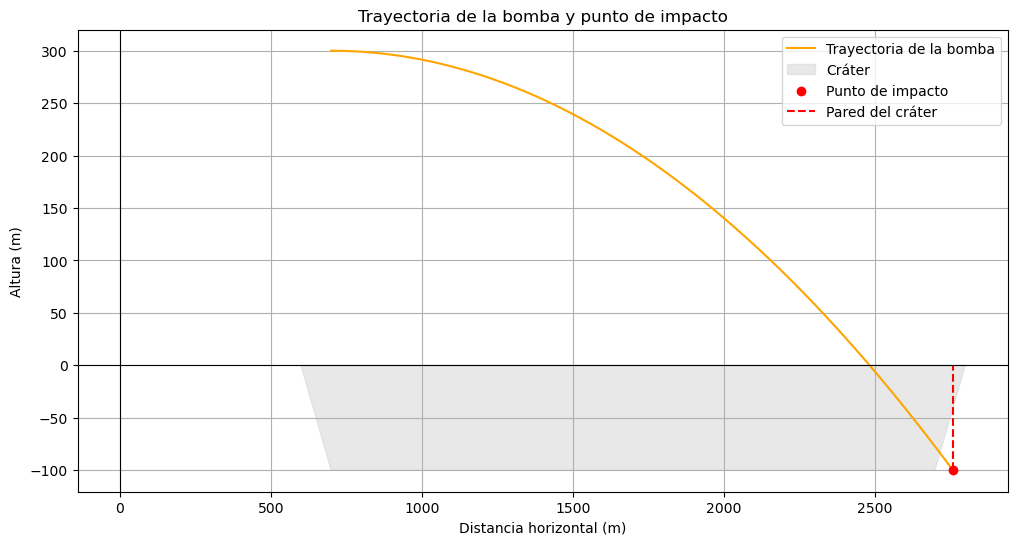

Punto de impacto: x = 2760.36 m, y = -100.00 m


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del problema
ha = 300  # Altura inicial de la bomba
hc = -100  # Altura del fondo del cráter
L = 2000  # Longitud del cráter
alpha = np.radians(45)  # Ángulo de inclinación de las paredes
d = 700  # Distancia horizontal inicial
v0 = 228  # Velocidad inicial de la bomba

# Componentes de velocidad
v0x = v0  # Velocidad horizontal
v0y = 0  # Velocidad vertical inicial
g = 9.81  # Aceleración debido a la gravedad

# Coordenadas del cráter (trapecio invertido)
x1 = d
x2 = d + (hc / np.tan(alpha))  # Fin de la pared izquierda
x3 = d + L - (hc / np.tan(alpha))  # Inicio de la pared derecha
x4 = d + L

# Función para calcular la trayectoria de la bomba
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

# Funciones de las paredes inclinadas del cráter
def pared_izquierda(x):
    return (hc / (x2 - x1)) * (x - x1)

def pared_derecha(x):
    return (hc / (x4 - x3)) * (x - x3)

# Evaluar impacto con la pared inclinada (izquierda o derecha)
def evaluar_impacto(x0, y0, v0x, v0y, x_inicio, x_fin, funcion_pared):
    for x in np.linspace(x_inicio, x_fin, 1000):
        y_trayectoria = trayectoria(x, x0, y0, v0x, v0y)
        y_pared = funcion_pared(x)
        if y_trayectoria <= y_pared:  # Detectar colisión
            return x, y_pared
    return None, None

# Verificar impacto en el cráter
impacto_x, impacto_y = None, None

# Evaluar impacto en la pared izquierda
impacto_x, impacto_y = evaluar_impacto(d, ha, v0x, v0y, x1, x2, pared_izquierda)

# Si no impactó en la pared izquierda, evaluar el fondo plano
if impacto_x is None:
    for x in np.linspace(x2, x3, 1000):
        y_trayectoria = trayectoria(x, d, ha, v0x, v0y)
        if y_trayectoria <= hc:
            impacto_x, impacto_y = x, hc
            break

# Si no impactó en el fondo plano, evaluar la pared derecha
if impacto_x is None:
    impacto_x, impacto_y = evaluar_impacto(d, ha, v0x, v0y, x3, x4, pared_derecha)

# Generar trayectoria de la bomba hasta el punto de impacto
x_trayectoria = np.linspace(d, impacto_x if impacto_x else d + L + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, d, ha, v0x, v0y)

# Graficar la trayectoria y el cráter
plt.figure(figsize=(12, 6))
plt.plot(x_trayectoria, y_trayectoria, color="orange", label="Trayectoria de la bomba")
plt.fill([x1, x2, x3, x4], [hc, 0, 0, hc], color="lightgrey", alpha=0.5, label="Cráter")
if impacto_x is not None and impacto_y is not None:
    plt.scatter(impacto_x, impacto_y, color="red", label="Punto de impacto", zorder=5)
    # Dibujar una línea que detiene la bomba en el impacto
    plt.plot([impacto_x, impacto_x], [impacto_y, 0], color="red", linestyle="--", label="Pared del cráter")
plt.axhline(0, color="black", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Trayectoria de la bomba y punto de impacto")
plt.xlabel("Distancia horizontal (m)")
plt.ylabel("Altura (m)")
plt.legend()
plt.grid()
plt.show()

if impacto_x is not None and impacto_y is not None:
    print(f"Punto de impacto: x = {impacto_x:.2f} m, y = {impacto_y:.2f} m")
else:
    print("La bomba no impactó dentro del cráter.")


C:\Users\Adrian Correa\AppData\Local\Temp\ipykernel_7064\4044569532.py:87: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  bomba.set_data(x_trayectoria[frame], y_trayectoria[frame])


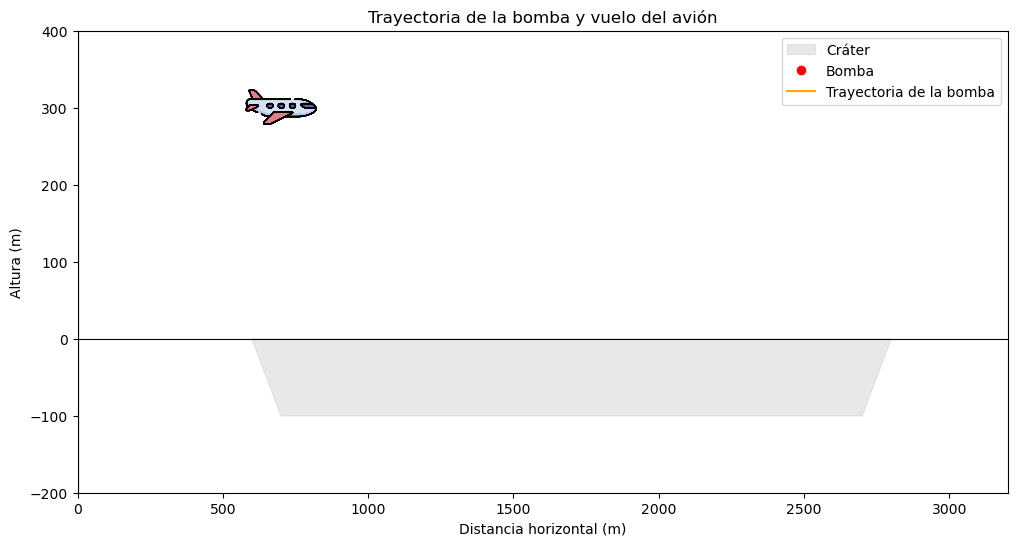

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Parámetros del problema
ha = 300  # Altura inicial de la bomba
hc = -100  # Altura del fondo del cráter
L = 2000  # Longitud del cráter
alpha = np.radians(45)  # Ángulo de inclinación de las paredes
d = 700  # Distancia horizontal inicial
v0 = 228  # Velocidad inicial de la bomba

# Componentes de velocidad
v0x = v0  # Velocidad horizontal
v0y = 0  # Velocidad vertical inicial
g = 9.81  # Aceleración debido a la gravedad

# Coordenadas del cráter
x1 = d
x2 = d + (hc / np.tan(alpha))
x3 = d + L - (hc / np.tan(alpha))
x4 = d + L

# Función para calcular la trayectoria
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

# Funciones de las paredes inclinadas
def pared_izquierda(x):
    return (hc / (x2 - x1)) * (x - x1)

def pared_derecha(x):
    return (hc / (x4 - x3)) * (x - x3)

# Verificar impacto
impacto_x, impacto_y = None, None
for x in np.linspace(d, d + L, 1000):
    y = trayectoria(x, d, ha, v0x, v0y)
    if x < x2 and y <= pared_izquierda(x):
        impacto_x, impacto_y = x, pared_izquierda(x)
        break
    elif x > x3 and y <= pared_derecha(x):
        impacto_x, impacto_y = x, pared_derecha(x)
        break
    elif x2 <= x <= x3 and y <= hc:
        impacto_x, impacto_y = x, hc
        break

# Si no se detecta impacto, usar un punto fuera del cráter
if impacto_x is None:
    impacto_x = d + L + 500  # Extender la trayectoria más allá del cráter
    impacto_y = trayectoria(impacto_x, d, ha, v0x, v0y)

# Datos de la trayectoria
x_trayectoria = np.linspace(d, impacto_x, 1000)
y_trayectoria = trayectoria(x_trayectoria, d, ha, v0x, v0y)

# Configuración de la animación
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, d + L + 500)
ax.set_ylim(hc - 100, ha + 100)
ax.set_title("Trayectoria de la bomba y vuelo del avión")
ax.set_xlabel("Distancia horizontal (m)")
ax.set_ylabel("Altura (m)")
ax.fill([x1, x2, x3, x4], [hc, 0, 0, hc], color="lightgrey", alpha=0.5, label="Cráter")
ax.axhline(0, color="black", linewidth=0.8)
ax.axvline(0, color="black", linewidth=0.8)
bomba, = ax.plot([], [], 'ro', label="Bomba")
trayectoria_line, = ax.plot([], [], color="orange", label="Trayectoria de la bomba")
plt.legend()

# Cargar la imagen del avión
avion_img = plt.imread("C:/Users/Adrian Correa/Desktop/Proyecto-metodos/avion.png")
imagebox = OffsetImage(avion_img, zoom=0.1)
avion_ab = AnnotationBbox(imagebox, (0, 0), frameon=False)
ax.add_artist(avion_ab)

# Función de actualización
def update(frame):
    avion_x = d + frame
    avion_ab.xy = (avion_x, ha)  # Actualizar posición del avión
    if frame < len(x_trayectoria):
        bomba.set_data(x_trayectoria[frame], y_trayectoria[frame])
        trayectoria_line.set_data(x_trayectoria[:frame], y_trayectoria[:frame])
    else:
        bomba.set_data([], [])  # Detener la bomba si excede la trayectoria
    return avion_ab, bomba, trayectoria_line

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(x_trayectoria) + 50, interval=20, blit=False)

# Mostrar la animación
plt.show()
